# Решение задачи движения
## Импорт библиотек

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from numpy import exp, cos, sin, sqrt, pi
import ray
ray.shutdown()
ray.init()

2023-06-11 15:18:37,399	INFO worker.py:1625 -- Started a local Ray instance.


Python version:,3.11.3
Ray version:,2.4.0


## Введение начальных условий

In [45]:
u = float(input('Введите энергию, с которой тело запустили'))
m = float(input('Введите массу снаряда'))
u = sqrt(2 * u / m)
alpha = float(input('Введите угол')) * pi / 180
cos_a = cos(alpha)
sin_a = sin(alpha)
a = float(input('Введите коэффициент пропорцианальности'))
g = 9.81
step = float(input('Введите шаг сетки времени'))

## Уравнение поверхности

In [46]:
def field(x:float):
    '''
    Функция поверхности
    '''
    return sqrt(abs(x)) * x * (2 + sin(x))

## Постройка графика

In [47]:
def draw(x1:np.ndarray, x2:np.ndarray, field_points:np.ndarray, x1_point:float, x2_point:float, time:float, figure:Figure | None = None)-> Figure:
    '''
    Функция, которая рисует график падения\n
    Параметры:
    -
    x1 - точки вдоль x1\n
    x2 - точки вдоль x2\n
    field_points - точки поверхности, определяемые\n
    '''
    if (figure is None):
        figure = plt.figure()
        figure.subplots_adjust(top=0.85)

    ax = figure.add_subplot()

    ax.plot(x1, x2)
    ax.plot(x1, field_points)
    ax.set_xlabel('x1', loc='right')
    ax.set_ylabel('x2', loc='top')
    ax.legend(['Снаряд', 'Поверхность'])
    ax.set_title(f"Координаты падения - ({x1_point:.4f}, {x2_point:.4f})\nВремя - {time:.4f}")
    ax.scatter(x1_point, x2_point, marker='x', s=20)

## Аналитическое решение
### Аналитеские координаты от времени

In [48]:
def x1_func(t:float, m = m, a = a, u=u, cos_a=cos_a)->float:
    if a != 0:
        return m/a*u*cos_a*(1 -exp(-a/m*t))
    else:
        return u*cos_a*t

def x2_func(t:float, m=m, a=a, u=u, sin_a=sin_a, g = g)->float:
    if a != 0:
        return m/a*(g*m/a + u*sin_a - g*t - exp(-a/m*t)*(g*m/a +u*sin_a))
    else:
        return -g *t *t/2 + u*sin_a*t

In [49]:
def ux(t: float) -> float: # Уравнение скорости по x
    if a != 0:
        return exp(-a/m*t)*u*cos_a
    else:
        return u * cos_a


def uy(t: float) -> float: # Уравнение скорости по y
    if a !=0:
        return exp(-a/m*t)*(g*m/a + u*sin_a) - g*m/a
    else:
        return -g*t + u*sin_a

### Метод секущих

In [50]:
def sekush(func, a:float, b:float, time_max:float)->float:
    '''
    Функция вычисялющая точку пересечения дфух графиков по методу секущих\n
    Параметры:
    -
    func - lambda функция разницы двух функций по типу lambda fi, x1, x2, t: fi(x1(t)) - x2(t)\n
    a и b - начало и конец отрезка пересечения\n
    time_max - максимальное кол-во итераций для поиска
    '''
    # x1 = a
    x = [a, b]
    for i in np.arange(time_max):
        if abs(x[0] - x[1]) < 1e-7:
            return x[0]
        y0 = func(field, x1_func, x2_func, x[0])
        y1 = func(field, x1_func, x2_func, x[1])
        x3 = x[0] - (x[1] - x[0])*y0/(y1 - y0)
        print(x3)
        x[0], x[1] = x[1], x3
        # y0 = func(field, x1_func, x2_func, a)
        # y1 = func(field, x1_func, x2_func, b)
        # x0 = b - (y1*(b - a))/(y1 - y0)
        # if y0 * func(field, x1_func, x2_func, x0) > 0:
        #     b = x0
        # else:
        #     a = x0
        # if abs(x1 - x0) < 1e-5:
        #     return x0
        # x1 = x0
    raise ValueError(f"Метод не сошелся за {time_max} итераций")

### Само решение

In [51]:
def solve_an(time_max:float, step:float):
    '''
    Решение аналитической задачи\n
    Параметры:
    -
    time_max - максимальное время, до которого решается задача\n
    step - шаг сетки
    '''
    t_pred = 0
    t = 0
    
    while(t < time_max or (x1_func(t) == 0 and x2_func(t) == 0)):
        if(field(x1_func(t)) > x2_func(t) ):
            break
        else:
            t_pred = t
            t = t + step

    if t == time_max:
        raise ValueError(f'Не получилось найти решение до {time_max}')
    
    f = lambda fi, x1, x2, t: fi(x1(t)) - x2(t)
    t = sekush(f, t_pred, t, time_max)

    print(t)
    
    x1 = x1_func(t)
    x2 = x2_func(t)
    return t, x1, x2

### Вывод графика

0.0
0.0
0.0


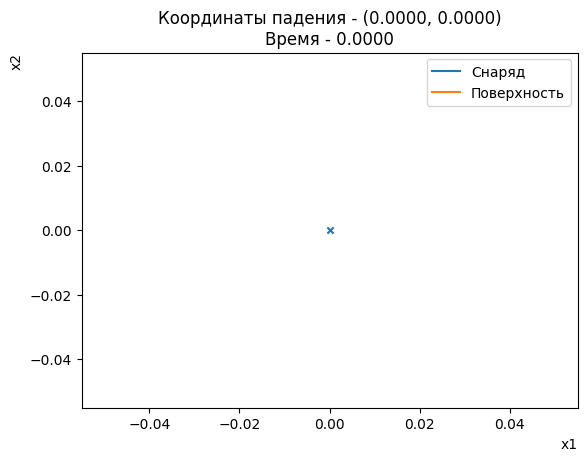

In [52]:
time, x1, x2 = solve_an(1_000_000, step)

times = np.arange(0, time + step, step, dtype=np.float128)

graph_ux = np.array([ux(t) for t in times], dtype=np.float128)
graph_uy = np.array([uy(t) for t in times], dtype=np.float128)
graph_x = np.array([x1_func(t) for t in times], dtype=np.float128)
graph_y = np.array([x2_func(t) for t in times], dtype=np.float128)
graph_field = np.array([field(x) for x in graph_x], dtype=np.float128)

draw(graph_x, graph_y, graph_field, x1, x2, time)


## Решение по Рунге-Кутты
### Скорости от времени

In [53]:
def x1_usk(t:float, x:float):
    return -x*a/m
def x2_usk(t:float, x:float):
    return -x*a/m - g

### Функции для построения полинома Лагранжа

In [54]:
def psi(x_array: np.ndarray, cix: float, i: int, x: float) -> float:
    '''
    Вычисление одного из членов интерполяционного полинома\n
    Параметры:
    -
    x_array - набор узлов\n
    cix - i-ый элемент базиса\n
    i - номер\n
    x - точка, в которой вычисляется значение
    '''
    result = cix
    for j, xj in enumerate(x_array):
        if (j != i):
            result = result * (x-xj)
    return result


def ci(xj: np.ndarray, x: float) -> float:
    '''
    Вычислегие i-го элемента константной части базиса Лагранжа\n
    Параметры:
    -
    xj - набор узлов\n
    x - i-ый узел
    '''
    c = 1
    for xi in xj:
        if xi != x:
            c = c * 1/(x - xi)
    return c


def y_x(yi: np.ndarray, xi: np.ndarray, cix:np.ndarray, x: float) -> float:
    '''
    Создание и вычисление интерполяционного полинома Лагранжа\n
    Параметры:
    -
    yi - набор значений функции\n
    xi - набор узлов\n
    cix - набор константных частей базиса\n
    x - в какой точке вычисляется полином
    '''
    fi = np.array(list(), dtype=np.float128)
    for i in range(len(yi)):
        fi = np.append(fi, psi(xi, cix[i], i, x))
    return (yi*fi).sum()

### Один пробег Рунге-Кутты 4-го порядка

In [55]:
# def runge_cord(x:float, y:np.ndarray, step:float, func, start_cord:float)->float:
#     '''
#     Вычисляет след координату по Рунге-Кутты\n
#     Параметры:
#     -
#     y - предыдущая точка\n
#     x - значение аргумента в предыдущей точки, в y\n
#     step - шаг сетки\n
#     func - функция, определяющая производную y по x
#     '''
#     k1 = runge_skor(x, y, step, func)
#     k2 = runge_skor(x + step/2, y + step*k1/2, step, func)
#     k3 = runge_skor(x + step/2, y + step*k2/2, step, func)
#     k4 = runge_skor(x + step, y + step*k3, step, func)
#     return start_cord + step/6 *(k1 + 2*(k2 + k3) + k4)

# def runge_skor(x:float, y:np.ndarray, step:float, func):
#     k1 = func(x, y[-1])
#     k2 = func(x + step/2, y[-1]+ step*k1/2)
#     k3 = func(x + step/2, y[-1] + step*k2/2)
#     k4 = func(x + step, y[-1] + step*k3)
#     return y[-1] + step/6 *(k1 + 2*(k2 + k3) + k4)

In [56]:
def runge_cord(x:float, y:np.ndarray, step:float, func, start_cord:float, mode=True)->float:
    '''
    Вычисляет след координату по Рунге-Кутты\n
    Параметры:
    -
    y - предыдущая точка\n
    x - значение аргумента в предыдущей точки, в y\n
    step - шаг сетки\n
    func - функция, определяющая производную y по x
    '''
    if len(y) < 4 or not mode:
        '''Проблеама в том, что мне нужны скорости на след координате'''
        k1 = y[-1]
        k2 = runge_skor(x + step/2, y[-1:], step/2, func, mode)
        k3 = runge_skor(x + step/2, y[-1:], step/2, func, mode)
        k4 = runge_skor(x + step, y[-1:], step, func, mode)
        return start_cord + step/6 *(k1 + 2*(k2 + k3) + k4)
    else:
        return start_cord + step*(55/24*y[-1] -59/24*y[-2] + 37/24*y[-3] - 9/24*y[-4])

def runge_skor(x:float, y:np.ndarray, step:float, func, mode=True):
    '''Вычисляет скорость в след момент времени с шагом step'''
    if len(y) < 4 or not mode:
        k1 = func(x, y[-1])
        k2 = func(x + step/2, y[-1]+ step*k1/2)
        k3 = func(x + step/2, y[-1] + step*k2/2)
        k4 = func(x + step, y[-1] + step*k3)
        return y[-1] + step/6 *(k1 + 2*(k2 + k3) + k4)
    else:
        return y[-1] + step*(55/24*func(x, y[-1]) -59/24*func(x,y[-2]) +37/24*func(x,y[-3]) -9/24*func(x,y[-4]))

### Сам алгоритм решения

In [57]:
@ray.remote
def solve_runge(time_max:float, step:float, mode:bool, cos_a=cos_a, sin_a=sin_a):
    '''
    Решает задачку движения по Рунге-Кутты\n
    Параметры:
    -
    time_max - максимальное время, до которого решается задача\n
    step - шаг сетки
    '''
    x = [0,0]
    y = [0,0]
    ux = [cos_a*u, cos_a*u]
    uy = [sin_a*u, sin_a*u]
    t = 0
    history_x = np.array(list(), dtype=np.float128)
    history_y = np.array(list(), dtype=np.float128)
    history_ux = np.array(list(), dtype=np.float128)
    history_uy = np.array(list(), dtype=np.float128)
    
    while(y[1] > field(x[1]) and t < time_max or (x[1] == 0 and y[1] == 0)):
        x[0], y[0], uy[0], ux[0] = x[1], y[1], uy[1], ux[1]
        history_x, history_y, history_uy, history_ux = np.append(history_x, x[0]), np.append(history_y, y[0]), np.append(history_uy, uy[0]), np.append(history_ux, ux[0])
        # x[1], y[1] = runge(x[1], t, step, ux), runge(y[1], t, step, uy)
        x[1], y[1], ux[1], uy[1] = runge_cord(t, history_ux[-4:], step, x1_usk, x[1], mode), runge_cord(t, history_uy[-4:], step, x2_usk, y[1], mode), runge_skor(t, history_ux[-4:], step, x1_usk, mode), runge_skor(t, history_uy[-4:], step, x2_usk, mode)
        
        t += step
    
    if t == time_max:
        raise ValueError(f'Не получилось решить по Рунге-Кутты за {time_max}')
    
    
    t-=step
    x_n = x[0]
    y_n = y[0]
    ux_n = np.array([ux[0]], dtype=np.float128)
    uy_n = np.array([uy[0]], dtype=np.float128)
    pred_step = step
    step /= 3
    x_slise = history_x[-1:]
    y_slize = history_y[-1:]
    for i in np.linspace(t, t+pred_step, 4, True)[1:-1]:
        x_n, y_n, ux_n_n, uy_n_n = runge_cord(i, ux_n, step, x1_usk, x_n), runge_cord(i, uy_n, step, x2_usk, y_n), runge_skor(i, ux_n, step, x1_usk), runge_skor(i, uy_n, step, x2_usk)
        ux_n, uy_n = np.append(ux_n, ux_n_n), np.append(uy_n, uy_n_n)
        x_slise, y_slize = np.append(x_slise, x_n), np.append(y_slize, y_n)
    history_x, history_y, history_uy, history_ux = np.append(history_x, x[1]), np.append(history_y, y[1]), np.append(history_uy, uy[1]), np.append(history_ux, ux[1])
    x_slise, y_slize = np.append(x_slise, x[1]), np.append(y_slize, y[1])
    cix = np.array([ci(x_slise, i) for i in x_slise], dtype=np.float128)

    # a, b = x[0], x[1]
    # x1 = a
    func = lambda y, x, ci, x0: y_x(y, x,ci, x0) - field(x0)
    
    for i in np.arange(time_max):
        if abs(x[0] - x[1]) < 1e-7:
            break
        y0 = func(y_slize, x_slise, cix, x[0])
        y1 = func(y_slize, x_slise, cix, x[1])
        x3 = x[0] - (x[1] - x[0])*y0/(y1 - y0)
        x[0], x[1] = x[1], x3
        # y0 = func(y_slize, x_slise, cix, a)
        # y1 = func(y_slize, x_slise, cix, b)
        # x0 = b - (y1*(b - a))/(y1 - y0)
        # if y0 * func(y_slize, x_slise, cix, x0) > 0:
        #     b = x0
        # else:
        #     a = x0
        # if abs(x1 - x0) < 1e-5:
        #     break
        # x1 = x0
    else:
        raise ValueError(f"Поиск то не сошелся за {time_max} итераций")
    
    x_fin = x[1]
    y_fin = y_x(y_slize, x_slise, cix, x[1])
    t_fin = y_x(np.array([t, t + step, t + 2*step, t + pred_step], dtype=np.float128), x_slise, cix, x[1])
    return x_fin, y_fin, t_fin, history_x, history_y, history_ux, history_uy

### Вывод графика

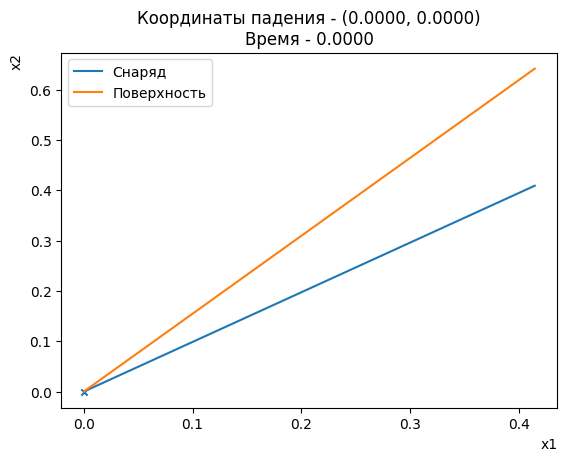

In [58]:
x_fin, y_fin, t_fin, x_hist, y_hist, ux_hist, uy_hist = ray.get(solve_runge.remote(1_000_000, step, False))

times = np.arange(0, time + step, step, dtype=np.float128)
field_points = np.array([field(i) for i in x_hist], dtype=np.float128)
draw(x_hist, y_hist, field_points, x_fin, y_fin, t_fin)

## Сравнение результатов
### Вывод обоих графиков

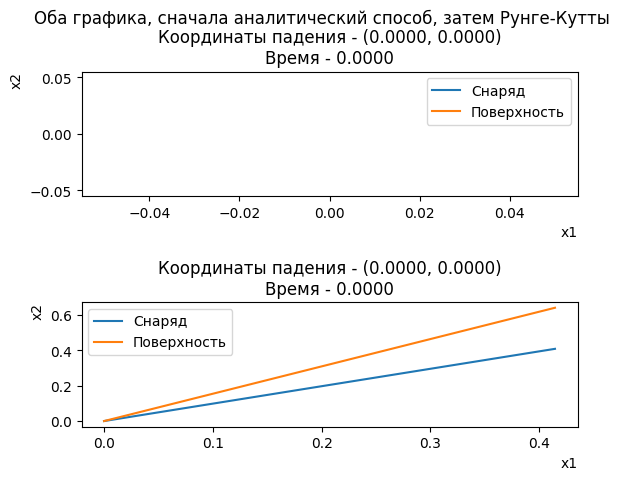

In [59]:
fig, axis = plt.subplots(2, 1)

fig.subplots_adjust(top=0.85, wspace=0.85, hspace=0.85)
fig.suptitle('Оба графика, сначала аналитический способ, затем Рунге-Кутты')
axis[0].plot(graph_x, graph_y)
axis[0].plot(graph_x, graph_field)
axis[0].set_xlabel('x1', loc='right')
axis[0].set_ylabel('x2', loc='top')
axis[0].legend(['Снаряд', 'Поверхность'])
axis[0].set_title(f"Координаты падения - ({x1:.4f}, {x2:.4f})\nВремя - {time:.4f}")

axis[1].plot(x_hist, y_hist)
axis[1].plot(x_hist, field_points)
axis[1].set_xlabel('x1', loc='right')
axis[1].set_ylabel('x2', loc='top')
axis[1].legend(['Снаряд', 'Поверхность'])
axis[1].set_title(f"Координаты падения - ({x_fin:.4f}, {y_fin:.4f})\nВремя - {t_fin:.4f}")

plt.show()

### График ошибки

[4.31078784e-16]
[3.55271368e-15]
[0.]
[0.]


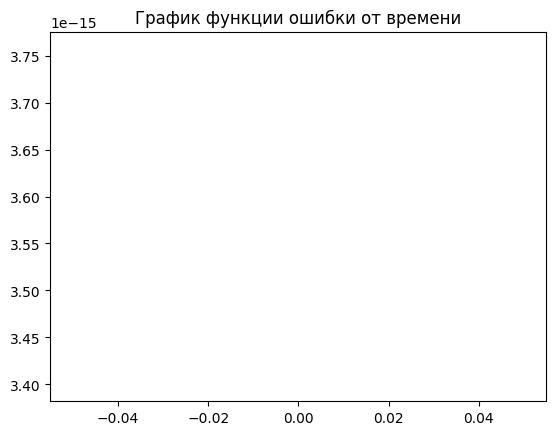

In [60]:
dif_ux = graph_ux[:ux_hist.shape[0]] - ux_hist[:graph_ux.shape[0]]
dif_uy = graph_uy[:uy_hist.shape[0]] - uy_hist[:graph_uy.shape[0]]
dif_x = graph_x[:x_hist.shape[0]] - x_hist[:graph_x.shape[0]]
dif_y = graph_y[:y_hist.shape[0]] - y_hist[:graph_y.shape[0]]
print(dif_ux)
print(dif_uy)
print(dif_x)
print(dif_y)
error = np.sqrt(dif_ux*dif_ux + dif_uy*dif_uy + dif_x*dif_x + dif_y*dif_y)
plt.title('График функции ошибки от времени')
plt.plot(times[:len(x_hist)], error)

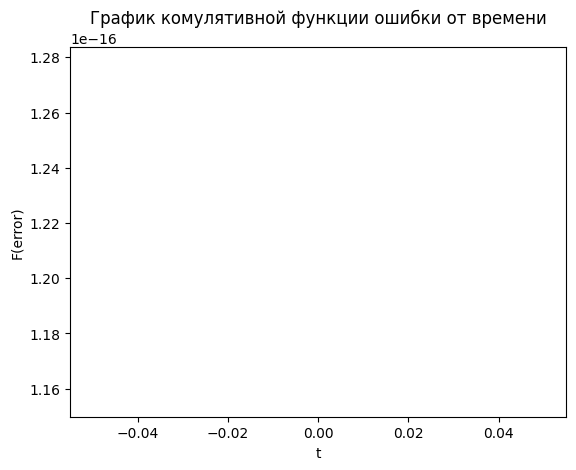

In [61]:
plt.plot(times[:len(x_hist)], step * np.cumsum(error, dtype=np.float128))
plt.title('График комулятивной функции ошибки от времени')
plt.xlabel('t')
plt.ylabel('F(error)')
plt.show()

0.016636633008599782
0.016648384383748313
0.01664859753413319
0.016648597402471925
0.01664859753413319
0.0035788766362717763443
0.016605037914583492
0.016645764116527746
0.016648603789996757
0.016648597401542207
0.016648603789996757
0.00022367320086807197942
0.016531567621101136
0.01664095611186105
0.01664864388846623
0.016648597384130683
0.01664864388846623
4.4182360665298174283e-05
0.016550936637582808
0.016634277410461803
0.016648670048724896
0.016648597348729786
0.016648670048724896
1.39795750542544987135e-05
0.016387586291312022
0.01661002616205612
0.016649125918091146
0.016648596347897227
0.01664859740244742
0.016648596347897227
5.7260339422226426473e-06
0.016249774490828275
0.01662216774378831
0.016649154726864433
0.016648596640987542
0.01664859740245161
0.016648596640987542
5.1696582202994112855e-06
0.016103228061845862
0.0165473279999721
0.01665155487057362
0.01664858185654747
0.016648597400099746
0.01664858185654747
7.690861842763273104e-06
0.016468654291311263
0.016599623012

Text(0, 0.5, 'error/(t_step)^4')

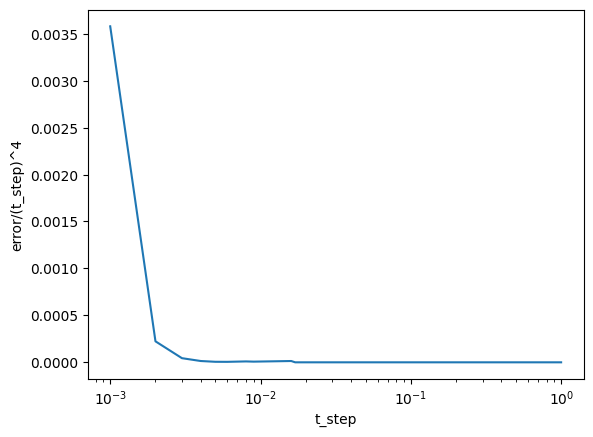

In [62]:
start = 0.001
end = 1
step = 0.001
errors = np.array(list(), ndmin=1)
mode = False
for i in np.arange(start, end, step):
   time, _, _ =solve_an(1_000_000, i)
   times = np.arange(0, time + i, i, dtype=np.float128)
   x1_an = np.array([x1_func(t) for t in times], dtype=np.float128)
   x2_an = np.array([x2_func(t) for t in times], dtype=np.float128)
   ux1_an = np.array([ux(t) for t  in times], dtype=np.float128)
   ux2_an = np.array([uy(t) for t  in times], dtype=np.float128)   
   _, _, _, x1_rung, x2_rung, ux1_rung, ux2_rung = ray.get(solve_runge.remote(1_000_000, i, mode))
   dif_ux = ux1_an[:ux1_rung.shape[0]] - ux1_rung[:ux1_an.shape[0]]
   dif_uy = ux2_an[:ux2_rung.shape[0]] - ux2_rung[:ux2_an.shape[0]]
   dif_x = x1_an[:x1_rung.shape[0]] - x1_rung[:x1_an.shape[0]]
   dif_y = x2_an[:x2_rung.shape[0]] - x2_rung[:x2_an.shape[0]]
   error_one = np.sqrt(dif_ux*dif_ux + dif_uy*dif_uy + dif_x*dif_x + dif_y*dif_y).max()/(i*i*i*i)
   print(error_one)
   errors = np.append(errors, error_one)

plt.plot(np.arange(start, end, step), errors)
plt.semilogx()
plt.xlabel('t_step')
plt.ylabel('error/(t_step)^4')

[0.        0.4146485]
[0.]
[0.         0.58241717]


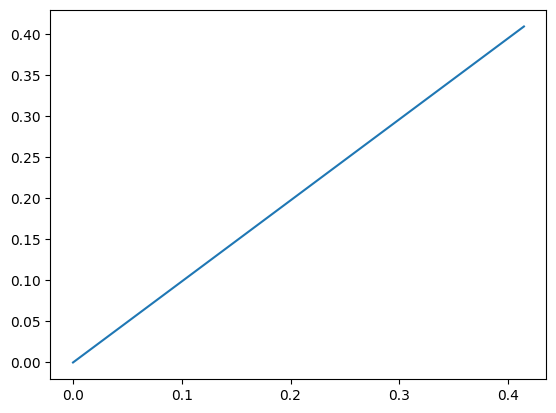

In [63]:
print(x_hist[-2:])
print(graph_x[-2:])
plt.plot(x_hist[-2:], y_hist[-2:])
plt.plot(graph_x[-2:], graph_y[-2:])
print(np.sqrt((x_hist[-2:] - graph_x[-2:])*(x_hist[-2:] - graph_x[-2:]) + (y_hist[-2:] - graph_y[-2:])*(y_hist[-2:] - graph_y[-2:])))

In [64]:
360/8

45.0

## Графики от углов

In [65]:
x_fin_array = np.array(list(), ndmin=1)
y_fin_array = np.array(list(), ndmin=1)
t_fin_array = np.array(list(), ndmin=1)

k = pi/180

for i in range(8, 361, 8):
    alphas = np.arange(i - 8, i, dtype=np.float128)*k
    cos_alphas = np.array([cos(j) for j in alphas], np.float128)
    sin_alphas = np.array([sin(j) for j in alphas], np.float128)
    operations = [solve_runge.remote(1_000_000, step, True, cos_alphas[j], sin_alphas[j]) for j in range(8)]
    results = ray.get(operations)
    # results = np.array(results, np.float128)
    x_fin_array = np.append(x_fin_array,[j[0] for j in results])
    y_fin_array = np.append(y_fin_array, [j[1] for j in results])
    t_fin_array = np.append(t_fin_array, [j[2] for j in results])

plt.plot(np.arange(0, 360), x_fin_array)
plt.plot(np.arange(0, 360), y_fin_array)
plt.plot(np.arange(0, 360), t_fin_array)
plt.show()


KeyboardInterrupt: 

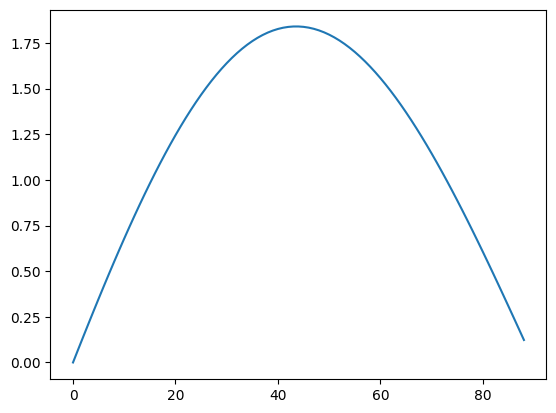

In [ ]:
plt.plot(np.arange(0, 89), x_fin_array[0:89])
plt.show()

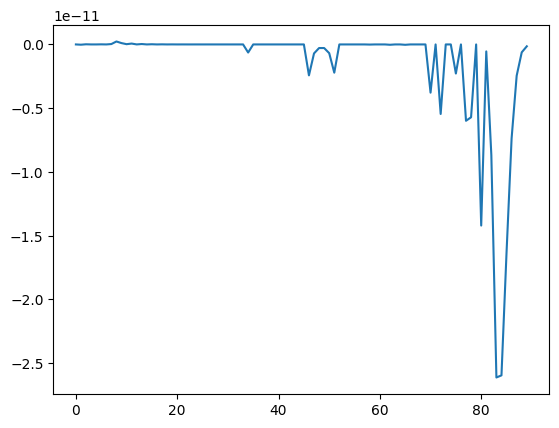

In [ ]:
plt.plot(np.arange(0, 90), y_fin_array[0:90])
plt.show()

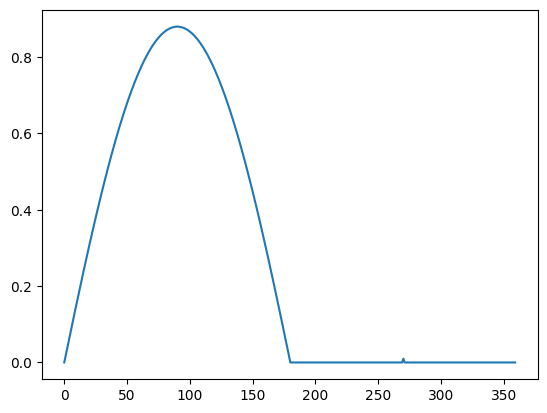

In [ ]:
plt.plot(np.arange(0, 360), t_fin_array)
plt.show()

# Обратная задача

In [ ]:
print(f"Истинный угол - {alpha}")
print(f"Коорд паданения - ({x_fin},{y_fin})")
k = pi/180
alphas = np.arange(0, 361, 45, np.float128)*k
operations = [solve_runge.remote(1_000_000, step, True, cos(j), sin(j)) for j in alphas]

def different(x1, x2):
    x1 = x_fin - x1
    x2 = y_fin - x2
    return sqrt(x1*x1+x2*x2)




Истинный угол - 0.7853981633974483
Коорд паданения - (1.8385810318069855,-5.959421664347104e-16)


1. Протестировать метод секущих, рунге, Адамса, интерполяцию
2. Выяснить почему график плохой
3. Переделать в классы и в пайтон файлы
4. 